In [1]:
import sys
import torch
import warnings
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
def fetch_batch(x, y, batch_index, batch_size):
    start = batch_index*batch_size
    end = batch_index*batch_size+batch_size
    x_batch = x[start:end]
    if y is not None:
        y_batch = y[start:end]
        return x_batch, y_batch
    else:
        return x_batch

<h2>Generate data</h2>

$$\mathbf{Y} = 0.5\mathbf{X} + 8\sin(0.3\mathbf{X}) + noise$$
where $noise$ - is a vector of $n$ normal sampled values.

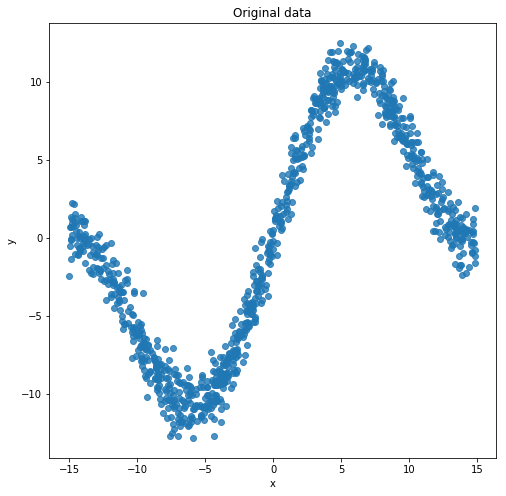

In [3]:
N = 3000
IN_DIM = 1
OUT_DIM = IN_DIM
x = np.random.uniform(-15., 15., (IN_DIM, N)).T.astype(np.float32)
noise = np.random.normal(size=(N, 1)).astype(np.float32)
y = 0.5*x+ 8.*np.sin(0.3*x) + noise
x_train, x_test, y_train, y_test = train_test_split(x, y)

plt.figure(figsize=(8, 8))
plt.title('Original data')
ax = sns.regplot(x[:1000], y[:1000], fit_reg=False)
ax.set(xlabel='x', ylabel='y')
plt.show()

<h2>Simple FeedForward Network</h2>

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim=IN_DIM, out_dim=OUT_DIM, layer_size=20):
        super(Net, self).__init__()
        self.fc = nn.Linear(input_dim, layer_size)
        self.logit = nn.Linear(layer_size, out_dim)

    def forward(self, x):
        x = F.sigmoid(self.fc(x))
        x = self.logit(x)
        return x

In [5]:
def train(net, x_train, y_train, x_test, y_test, epoches=2000, lr=0.1):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    N_EPOCHES = epoches
    BS = 1500
    n_batches = int(np.ceil(x_train.shape[0] / BS))
    train_losses = []
    test_losses = []
    for i in range(N_EPOCHES):
        for bi in range(n_batches):
            x_batch, y_batch = fetch_batch(x_train, y_train, bi, BS)
            x_train_var = Variable(torch.from_numpy(x_batch))
            y_train_var = Variable(torch.from_numpy(y_batch))
            optimizer.zero_grad()
            outputs = net(x_train_var)
            loss = criterion(outputs, y_train_var)
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            x_test_var = Variable(torch.from_numpy(x_test))
            y_test_var = Variable(torch.from_numpy(y_test))
            outputs = net(x_test_var)
            test_loss = criterion(outputs, y_test_var)
            test_losses.append(test_loss.item())
            train_losses.append(loss.item())
            if i%100 == 0:
                sys.stdout.write('\r Iter: %d, test loss: %.5f, train loss: %.5f'
                                 %(i, test_loss.item(), loss.item()))
                sys.stdout.flush()
    return train_losses, test_losses

In [6]:
net = Net()
print(net)
train_losses, test_losses = train(net, x_train, y_train, x_test, y_test)

Net(
  (fc): Linear(in_features=1, out_features=20, bias=True)
  (logit): Linear(in_features=20, out_features=1, bias=True)
)
 Iter: 1900, test loss: 1.00003, train loss: 0.94219

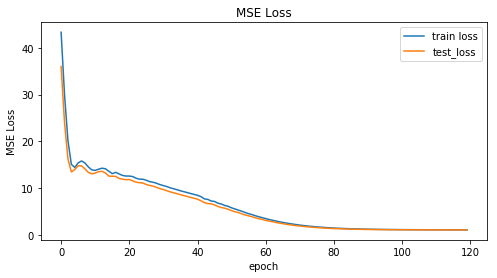

In [7]:
fig = plt.figure(figsize=(8, 4))
ax = sns.lineplot(np.arange(len(train_losses[:120])), train_losses[:120])
ax = sns.lineplot(np.arange(len(test_losses[:120])), test_losses[:120])
ax.set(xlabel='epoch', ylabel='MSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('MSE Loss')
plt.show()

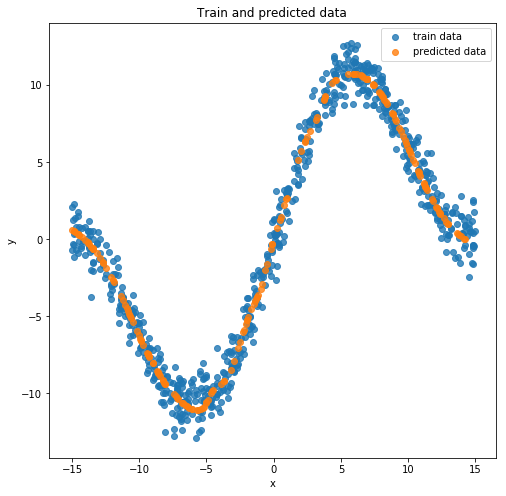

In [8]:
out = net(Variable(torch.from_numpy(x_test)))
fig = plt.figure(figsize=(8, 8))
ax = sns.regplot(x_test[:1000], y_test[:1000], fit_reg=False)
ax = sns.regplot(x_test[:200], out.data.numpy()[:200], fit_reg=False)
ax.set(xlabel='x', ylabel='y')
plt.title('Train and predicted data')
plt.legend(['train data', 'predicted data'])
plt.show()

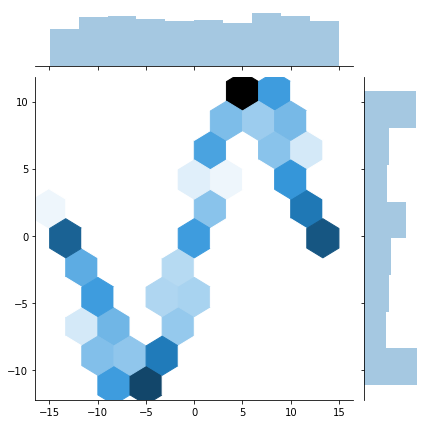

In [9]:
sns.jointplot(x_test, out.data.numpy(), kind="hex")
plt.show()

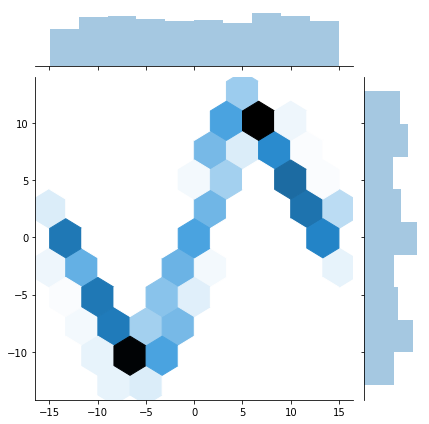

In [10]:
sns.jointplot(x_test, y_test, kind="hex")
plt.show()

<h2>Inverse problem</h2>

$$\mathbf{X} = 0.5\mathbf{Y} + 8\sin(0.3\mathbf{Y}) + noise$$
where $noise$ - is a vector of $n$ normal sampled values.

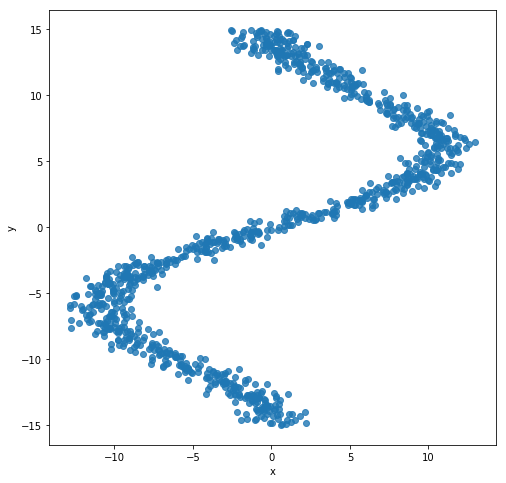

In [4]:
x_train_inv = y_train
y_train_inv = x_train
x_test_inv = y_train
y_test_inv = x_train
plt.figure(figsize=(8, 8))
ax = sns.regplot(x_train_inv[:1000], y_train_inv[:1000], fit_reg=False)
ax.set(xlabel='x', ylabel='y')
plt.show()

In [12]:
inv_train_losses, inv_test_losses = train(net, x_train_inv, y_train_inv, x_test_inv, y_test_inv)

 Iter: 1900, test loss: 37.92578, train loss: 37.94692

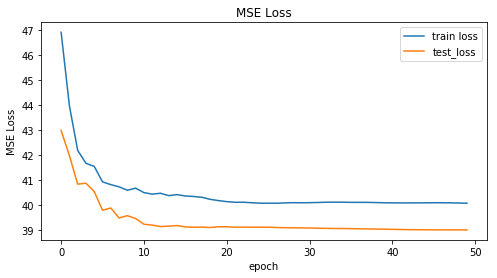

In [13]:
fig = plt.figure(figsize=(8, 4))
ax = sns.lineplot(np.arange(len(inv_train_losses[:50])), inv_train_losses[:50])
ax = sns.lineplot(np.arange(len(inv_test_losses[:50])), inv_test_losses[:50])
ax.set(xlabel='epoch', ylabel='MSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('MSE Loss')
plt.show()

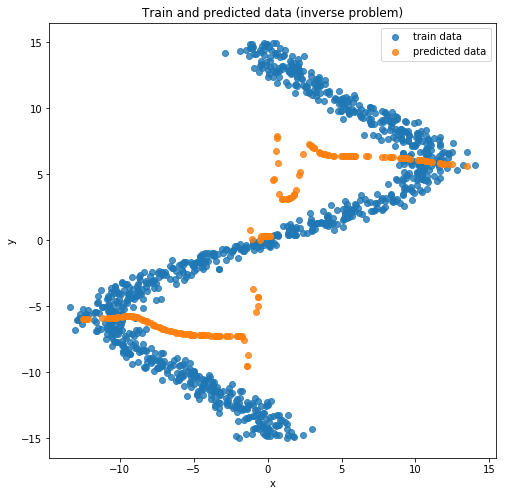

In [14]:
out = net(Variable(torch.from_numpy(x_test_inv)))
fig = plt.figure(figsize=(8, 8))
ax = sns.regplot(x_test_inv[:1000], y_test_inv[:1000], fit_reg=False)
ax = sns.regplot(x_test_inv[:200], out.data.numpy()[:200], fit_reg=False)
ax.set(xlabel='x', ylabel='y')
plt.title('Train and predicted data (inverse problem)')
plt.legend(['train data', 'predicted data'])
plt.show()

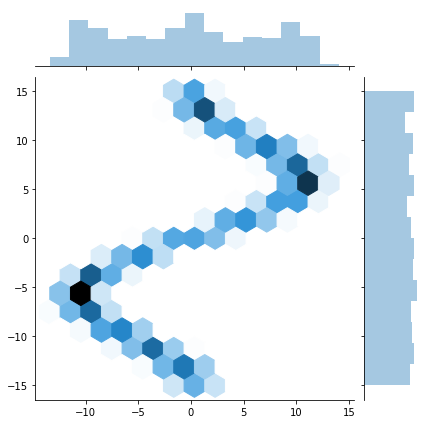

In [15]:
sns.jointplot(x_test_inv, y_test_inv, kind="hex")
plt.show()

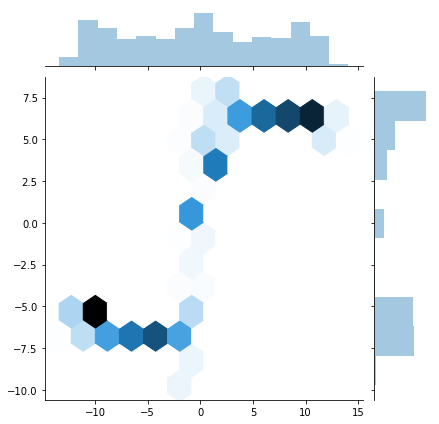

In [16]:
sns.jointplot(x_test_inv, out.data.numpy(), kind="hex")
plt.show()

<h2>Mixture density network</h2>

In [5]:
COEFS = 30
class MDN(nn.Module):

    def __init__(self, input_dim=IN_DIM, out_dim=OUT_DIM, layer_size=50, coefs=COEFS):
        super(MDN, self).__init__()
        self.fc = nn.Linear(input_dim, layer_size)
        self.pi = nn.Linear(layer_size, coefs)
        self.mu = nn.Linear(layer_size, out_dim*coefs) # mean
        self.sigma_sq = nn.Linear(layer_size, coefs) # variance
        self.out_dim = out_dim
        self.coefs = coefs

    def forward(self, x):
        x = F.tanh(self.fc(x))
        pi = F.softmax(self.pi(x), dim=1)
        sigma_sq = torch.exp(self.sigma_sq(x))
        mu = self.mu(x)
        return pi, mu, sigma_sq
    
def gaussian_pdf(x, mu, sigma_sq):
    return (1/torch.sqrt(2*np.pi*sigma_sq)) * torch.exp((-1/(2*sigma_sq)) * torch.norm((x-mu), 2, 1)**2)

def loss_fn(y, pi, mu, sigma_sq):
    losses = Variable(torch.zeros(y.shape[0]))  # p(y|x)
    for i in range(COEFS):
        likelihood = gaussian_pdf(y,
                                  mu[:, i*OUT_DIM:(i+1)*OUT_DIM],
                                  sigma_sq[:, i])
        prior = pi[:, i]
        losses += prior * likelihood
    loss = torch.mean(-torch.log(losses))
    return loss

In [6]:
def train_mdn(net, x_train, y_train, x_test, y_test, epoches=1000):
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    N_EPOCHES = epoches
    BS = 1500
    n_batches = int(np.ceil(x_train.shape[0] / BS))
    train_losses = []
    test_losses = []
    for i in range(N_EPOCHES):
        for bi in range(n_batches):
            x_batch, y_batch = fetch_batch(x_train, y_train, bi, BS)
            x_train_var = Variable(torch.from_numpy(x_batch))
            y_train_var = Variable(torch.from_numpy(y_batch))
            optimizer.zero_grad()
            pi, mu, sigma_sq = net(x_train_var)
            loss = loss_fn(y_train_var, pi, mu, sigma_sq)
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            if i%10 == 0:
                x_test_var = Variable(torch.from_numpy(x_test))
                y_test_var = Variable(torch.from_numpy(y_test))
                pi, mu, sigma_sq = net(x_test_var)
                test_loss = loss_fn(y_test_var, pi, mu, sigma_sq)
                train_losses.append(loss.item())
                test_losses.append(test_loss.item())
                sys.stdout.write('\r Iter: %d, test loss: %.5f, train loss: %.5f'
                                 %(i, test_loss.item(), loss.item()))
                sys.stdout.flush()
    return train_losses, test_losses

In [7]:
mdn_net = MDN()
print(mdn_net)
mdn_train_losses, mdn_test_losses = train_mdn(mdn_net, x_train_inv, y_train_inv, x_test_inv, y_test_inv)

MDN(
  (fc): Linear(in_features=1, out_features=50, bias=True)
  (pi): Linear(in_features=50, out_features=30, bias=True)
  (mu): Linear(in_features=50, out_features=30, bias=True)
  (sigma_sq): Linear(in_features=50, out_features=30, bias=True)
)
 Iter: 990, test loss: 1.66197, train loss: 1.61869

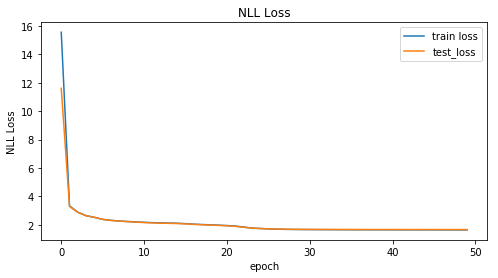

In [20]:
fig = plt.figure(figsize=(8, 4))
ax = sns.lineplot(np.arange(len(mdn_train_losses[:50])), mdn_train_losses[:50])
ax = sns.lineplot(np.arange(len(mdn_test_losses[:50])), mdn_test_losses[:50])
ax.set(xlabel='epoch', ylabel='NLL Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('NLL Loss')
plt.show()

<h2>Mixture density network's results</h2>

In [8]:
def most_prob_mu(pi, mu):
    n = pi.shape[0]
    _, max_component = torch.max(pi, 1)
    out = Variable(torch.zeros(n, OUT_DIM))
    for i in range(n):
        for j in range(OUT_DIM):
            out[i, j] = mu[i, max_component.data[i]*OUT_DIM+j]
    return out

def most_n_mu(pi, mu, samples=10):
    n = pi.shape[0]
    out = Variable(torch.zeros(n, samples, OUT_DIM))
    for i in range(n):
        args = np.argsort(np.array(pi.data[i]))[::-1][:samples]
        for j in range(samples):
            for od in range(OUT_DIM):
                out[i, j, od] = mu[i, args[j]*OUT_DIM+od]
    return out

def rand_n_sample_cumulative(pi, mu, sigmasq, samples=10):
    n = pi.shape[0]
    out = Variable(torch.zeros(n, samples, OUT_DIM))
    for i in range(n):
        for j in range(samples):
            u = np.random.uniform()
            prob_sum = 0
            for k in range(COEFS):
                prob_sum += pi.data[i, k]
                if u < prob_sum:
                    for od in range(OUT_DIM):
                        sample = np.random.normal(mu.data[i, k*OUT_DIM+od], np.sqrt(sigmasq.data[i, k]))
                        out[i, j, od] = sample
                    break
    return out

def n_best_sample(pi, mu, sigma_sq, samples=10):
    n = pi.shape[0]
    out = Variable(torch.zeros(n, samples, OUT_DIM))
    for i in range(n):
        args = np.argsort(np.array(pi.data[i]))[::-1][:samples]
        for j in range(samples):
            for od in range(OUT_DIM):
                sample = np.random.normal(mu.data[i, args[j]*OUT_DIM+od], np.sqrt(sigma_sq.data[i, args[j]]))
                out[i, j, od] = sample
    return out

In [9]:
pi, mu, sigma_sq = mdn_net(Variable(torch.from_numpy(x_test_inv)))
most_prob_mu_vals = most_prob_mu(pi, mu)
n_mu_vals = most_n_mu(pi, mu, samples=4)
preds = rand_n_sample_cumulative(pi, mu, sigma_sq, samples=10)
fn_preds = n_best_sample(pi, mu, sigma_sq, samples=10)

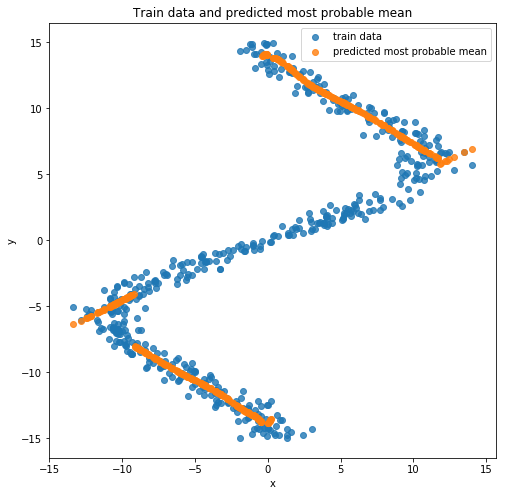

In [23]:
fig = plt.figure(figsize=(8, 8))
ax = sns.regplot(x_test_inv[:500], y_test_inv[:500], fit_reg=False)
ax = sns.regplot(x_test_inv[:500], most_prob_mu_vals.data.numpy()[:500], fit_reg=False)
ax.set(xlabel='x', ylabel='y')
plt.title('Train data and predicted most probable mean')
plt.legend(['train data', 'predicted most probable mean'])
plt.show()

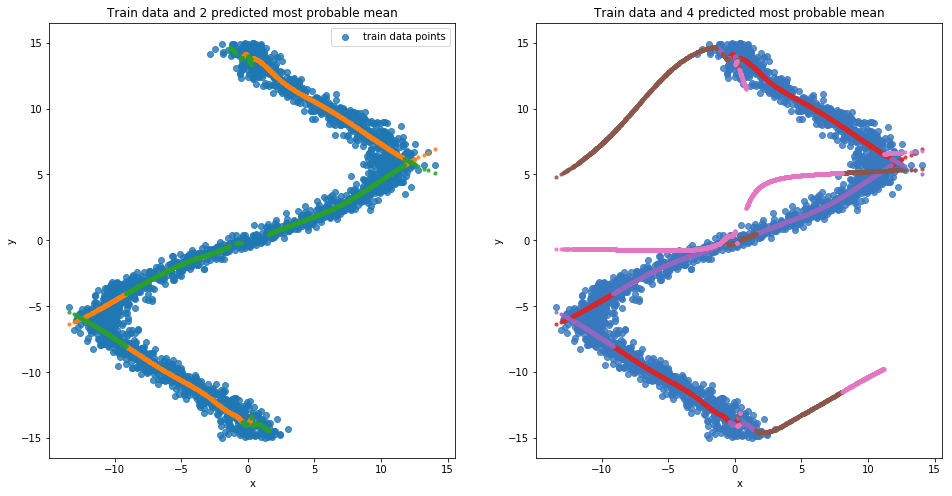

In [24]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1 = sns.regplot(x_test_inv, y_test_inv, fit_reg=False, ax=axes[0])
for i in range(2):
    ax1 = sns.regplot(x_test_inv, n_mu_vals.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':10}, ax=axes[0])
ax1.legend(['train data points'])
ax1.set_title('Train data and 2 predicted most probable mean')
ax1.set(xlabel='x', ylabel='y')

ax2 = sns.regplot(x_test_inv, y_test_inv, fit_reg=False, ax=axes[1], color=sns.xkcd_palette(['windows blue'])[0])
for i in range(4):
    ax2 = sns.regplot(x_test_inv, n_mu_vals.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':10}, ax=axes[1])
ax2.set_title('Train data and 4 predicted most probable mean')
ax2.set(xlabel='x', ylabel='y')
plt.show()

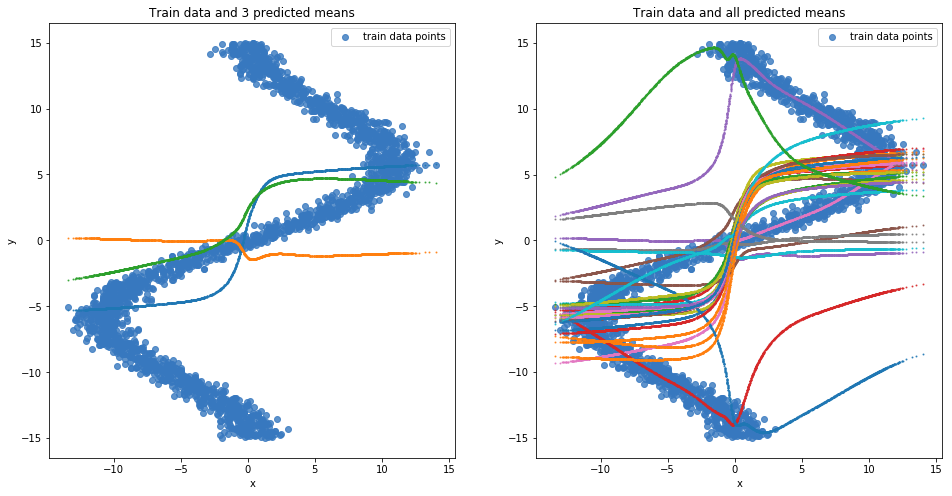

In [25]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1 = sns.regplot(x_test_inv, y_test_inv, fit_reg=False, ax=axes[0], color=sns.xkcd_palette(['windows blue'])[0])
for i in range(3):
    ax1 = sns.regplot(x_test_inv, mu.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':1}, ax=axes[0])
ax1.legend(['train data points'])
ax1.set_title('Train data and 3 predicted means')
ax1.set(xlabel='x', ylabel='y')

ax2 = sns.regplot(x_test_inv, y_test_inv, fit_reg=False, ax=axes[1], color=sns.xkcd_palette(['windows blue'])[0])
for i in range(mu.data.numpy().shape[1]):
    ax2 = sns.regplot(x_test_inv, mu.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':1}, ax=axes[1])
ax2.legend(['train data points'])
ax2.set_title('Train data and all predicted means')
ax2.set(xlabel='x', ylabel='y')
plt.show()

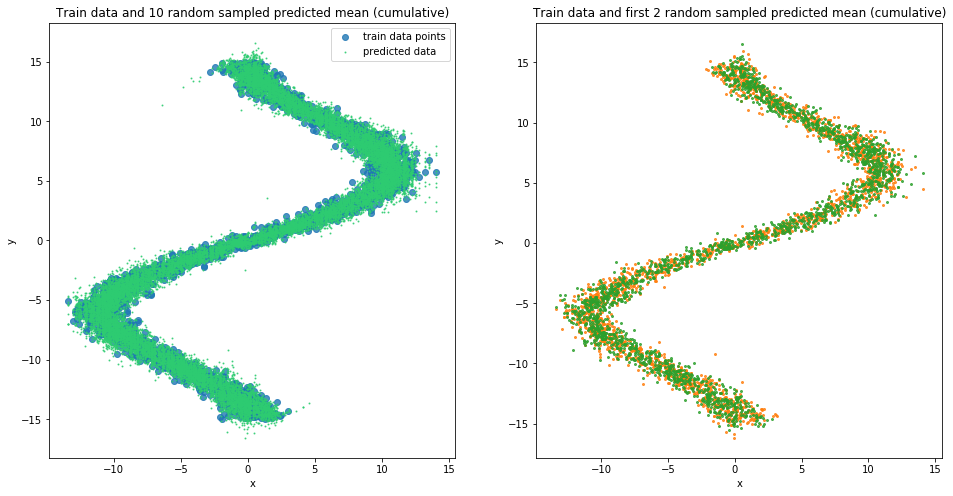

In [26]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1 = sns.regplot(x_test_inv, y_test_inv, fit_reg=False, ax=axes[0])
for i in range(preds.shape[1]):
    ax1 = sns.regplot(x_test_inv, preds.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':1}, ax=axes[0], color=sns.color_palette(['#2ecc71'])[0])
ax1.legend(['train data points', 'predicted data'])
ax1.set_title('Train data and 10 random sampled predicted mean (cumulative)')
ax1.set(xlabel='x', ylabel='y')

for i in range(2):
    ax2 = sns.regplot(x_test_inv, preds.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':4}, ax=axes[1])
ax2.set_title('Train data and first 2 random sampled predicted mean (cumulative)')
ax2.set(xlabel='x', ylabel='y')
plt.show()

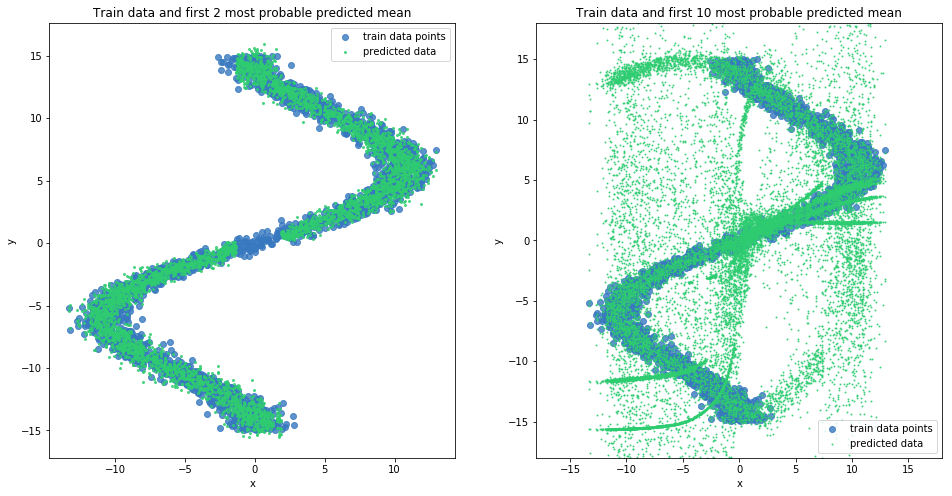

In [49]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1 = sns.regplot(x_test_inv, y_test_inv, fit_reg=False, ax=axes[0], color=sns.xkcd_palette(['windows blue'])[0])
for i in range(2):
    ax1 = sns.regplot(x_test_inv, fn_preds.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':4}, ax=axes[0], color=sns.color_palette(['#2ecc71'])[0])
ax1.set_title('Train data and first 2 most probable predicted mean')
ax1.legend(['train data points', 'predicted data'])
ax1.set(xlabel='x', ylabel='y')

ax2 = sns.regplot(x_test_inv, y_test_inv, fit_reg=False, ax=axes[1], color=sns.xkcd_palette(['windows blue'])[0])
for i in range(fn_preds.shape[1]):
    ax2 = sns.regplot(x_test_inv, fn_preds.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':1}, ax=axes[1], color=sns.color_palette(['#2ecc71'])[0])
ax2.set_title('Train data and first 10 most probable predicted mean')
ax2.legend(['train data points', 'predicted data'])
ax2.set(xlabel='x', ylabel='y')
ax2.set_xlim(-18, 18)
ax2.set_ylim(-18, 18)
plt.show()

<h2>More Complex Data</h2>

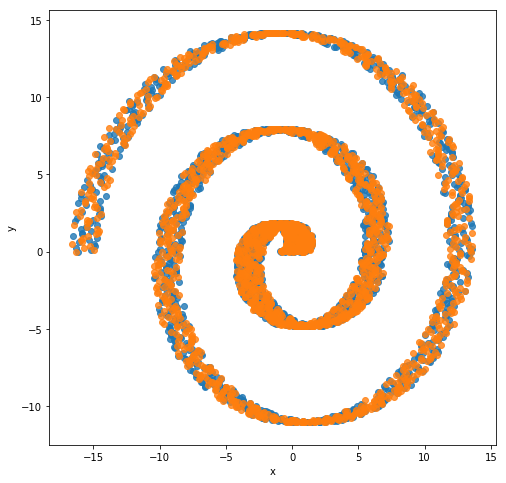

In [7]:
N = 2000
x_train_compl = []
y_train_compl = []
x_test_compl = []
y_test_compl = []
noise_train = np.random.uniform(-1, 1, (N, IN_DIM)).astype(np.float32)
noise_test = np.random.uniform(-1, 1, (N, IN_DIM)).astype(np.float32)
for i, theta in enumerate(np.linspace(0, 5*np.pi, N).astype(np.float32)):
    r = ((theta))
    x_train_compl.append(r*np.cos(theta) + noise_train[i])
    y_train_compl.append(r*np.sin(theta))
    x_test_compl.append(r*np.cos(theta) + noise_test[i])
    y_test_compl.append(r*np.sin(theta))

x_train_compl = np.array(x_train_compl).reshape((-1, 1))
y_train_compl = np.array(y_train_compl).reshape((-1, 1))
x_test_compl = np.array(x_test_compl).reshape((-1, 1))
y_test_compl = np.array(y_test_compl).reshape((-1, 1))
plt.figure(figsize=(8,8))
ax = sns.regplot(x_train_compl, y_train_compl, fit_reg=False)
ax = sns.regplot(x_test_compl, y_test_compl, fit_reg=False)
ax.set(xlabel='x', ylabel='y')
plt.show()

<h3>Train spiral data with simple FFN</h3>

In [33]:
net = Net()
print(net)
train_losses, test_losses = train(net, x_train_compl, y_train_compl, x_test_compl, y_test_compl, epoches=1000)

Net(
  (fc): Linear(in_features=1, out_features=20, bias=True)
  (logit): Linear(in_features=20, out_features=1, bias=True)
)
 Iter: 900, test loss: 42.88358, train loss: 52.46170

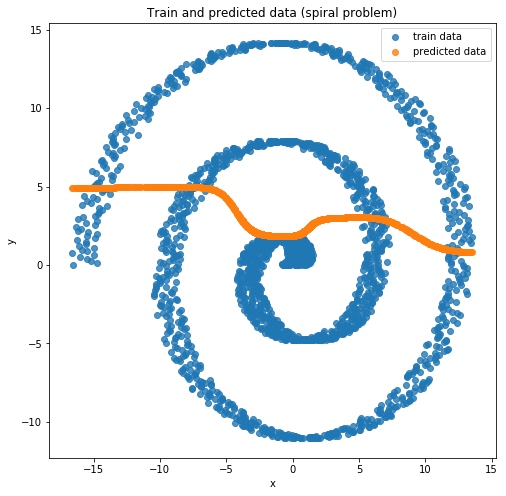

In [37]:
out = net(Variable(torch.from_numpy(x_test_compl)))
fig = plt.figure(figsize=(8, 8))
ax = sns.regplot(x_test_compl, y_test_compl, fit_reg=False)
ax = sns.regplot(x_test_compl, out.data.numpy(), fit_reg=False)
ax.set(xlabel='x', ylabel='y')
plt.title('Train and predicted data (spiral problem)')
plt.legend(['train data', 'predicted data'])
plt.show()

<h3>Train spiral data with MDN</h3>

In [26]:
mdn_net = MDN(layer_size=40)
print(mdn_net)
mdn_train_losses, mdn_test_losses = train_mdn(mdn_net, x_train_compl, y_train_compl, x_test_compl, y_test_compl, epoches=2000)

MDN(
  (fc): Linear(in_features=1, out_features=40, bias=True)
  (pi): Linear(in_features=40, out_features=30, bias=True)
  (mu): Linear(in_features=40, out_features=30, bias=True)
  (sigma_sq): Linear(in_features=40, out_features=30, bias=True)
)
 Iter: 1990, test loss: 1.83177, train loss: 1.60113

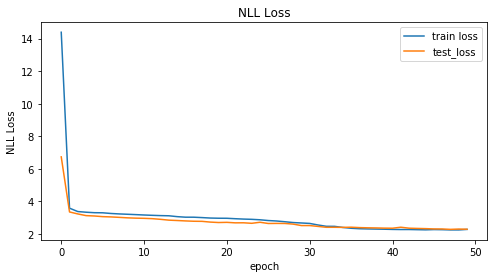

In [27]:
fig = plt.figure(figsize=(8, 4))
ax = sns.lineplot(np.arange(len(mdn_train_losses[:50])), mdn_train_losses[:50])
ax = sns.lineplot(np.arange(len(mdn_test_losses[:50])), mdn_test_losses[:50])
ax.set(xlabel='epoch', ylabel='NLL Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('NLL Loss')
plt.show()

In [28]:
pi, mu, sigma_sq = mdn_net(Variable(torch.from_numpy(x_test_compl)))
most_prob_mu_vals = most_prob_mu(pi, mu)
n_mu_vals = most_n_mu(pi, mu, samples=4)
preds = rand_n_sample_cumulative(pi, mu, sigma_sq, samples=10)
fn_preds = n_best_sample(pi, mu, sigma_sq, samples=10)

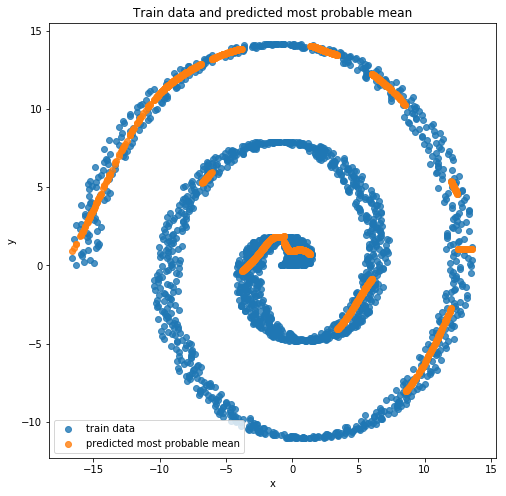

In [29]:
fig = plt.figure(figsize=(8, 8))
ax = sns.regplot(x_test_compl, y_test_compl, fit_reg=False)
ax = sns.regplot(x_test_compl, most_prob_mu_vals.data.numpy(), fit_reg=False)
ax.set(xlabel='x', ylabel='y')
plt.title('Train data and predicted most probable mean')
plt.legend(['train data', 'predicted most probable mean'])
plt.show()

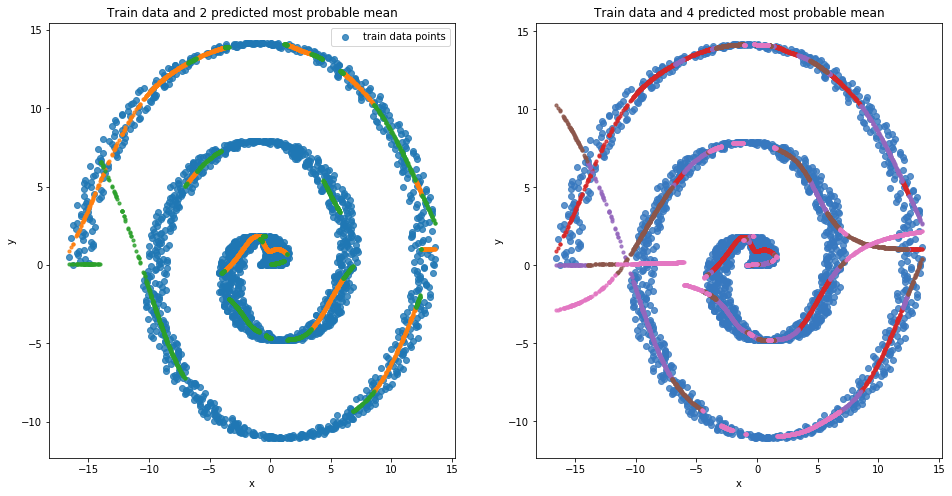

In [30]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1 = sns.regplot(x_test_compl, y_test_compl, fit_reg=False, ax=axes[0])
for i in range(2):
    ax1 = sns.regplot(x_test_compl, n_mu_vals.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':10}, ax=axes[0])
ax1.legend(['train data points'])
ax1.set_title('Train data and 2 predicted most probable mean')
ax1.set(xlabel='x', ylabel='y')

ax2 = sns.regplot(x_test_compl, y_test_compl, fit_reg=False, ax=axes[1], color=sns.xkcd_palette(['windows blue'])[0])
for i in range(4):
    ax2 = sns.regplot(x_test_compl, n_mu_vals.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':10}, ax=axes[1])
ax2.set_title('Train data and 4 predicted most probable mean')
ax2.set(xlabel='x', ylabel='y')
plt.show()

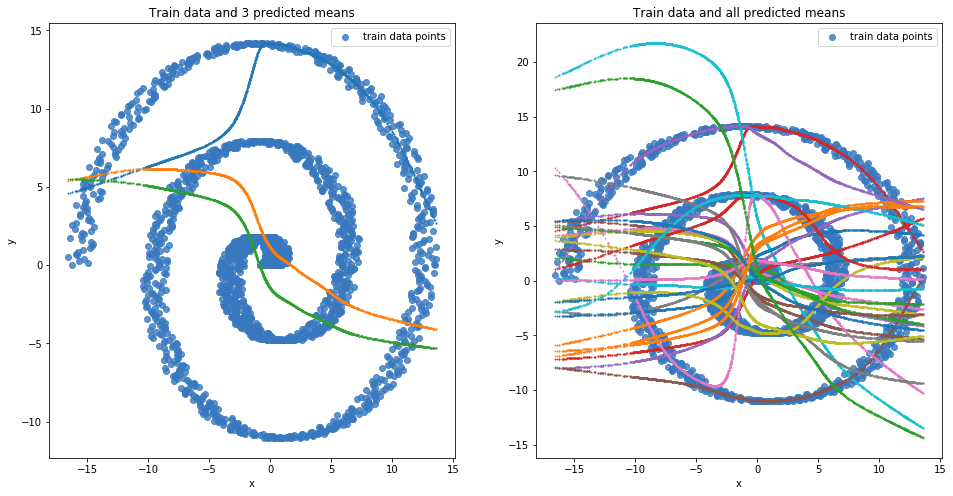

In [31]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1 = sns.regplot(x_test_compl, y_test_compl, fit_reg=False, ax=axes[0], color=sns.xkcd_palette(['windows blue'])[0])
for i in range(3):
    ax1 = sns.regplot(x_test_compl, mu.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':1}, ax=axes[0])
ax1.legend(['train data points'])
ax1.set_title('Train data and 3 predicted means')
ax1.set(xlabel='x', ylabel='y')

ax2 = sns.regplot(x_test_compl, y_test_compl, fit_reg=False, ax=axes[1], color=sns.xkcd_palette(['windows blue'])[0])
for i in range(mu.data.numpy().shape[1]):
    ax2 = sns.regplot(x_test_compl, mu.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':1}, ax=axes[1])
ax2.legend(['train data points'])
ax2.set_title('Train data and all predicted means')
ax2.set(xlabel='x', ylabel='y')
plt.show()

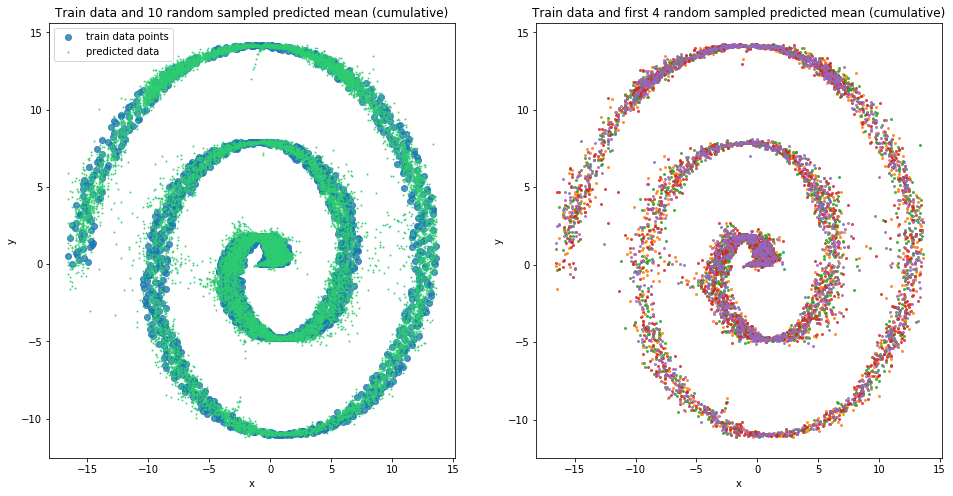

In [33]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1 = sns.regplot(x_test_compl, y_test_compl, fit_reg=False, ax=axes[0])
for i in range(preds.shape[1]):
    ax1 = sns.regplot(x_test_compl, preds.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':1}, ax=axes[0], color=sns.color_palette(['#2ecc71'])[0])
ax1.legend(['train data points', 'predicted data'])
ax1.set_title('Train data and 10 random sampled predicted mean (cumulative)')
ax1.set(xlabel='x', ylabel='y')

for i in range(4):
    ax2 = sns.regplot(x_test_compl, preds.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':4}, ax=axes[1])
ax2.set_title('Train data and first 4 random sampled predicted mean (cumulative)')
ax2.set(xlabel='x', ylabel='y')
plt.show()

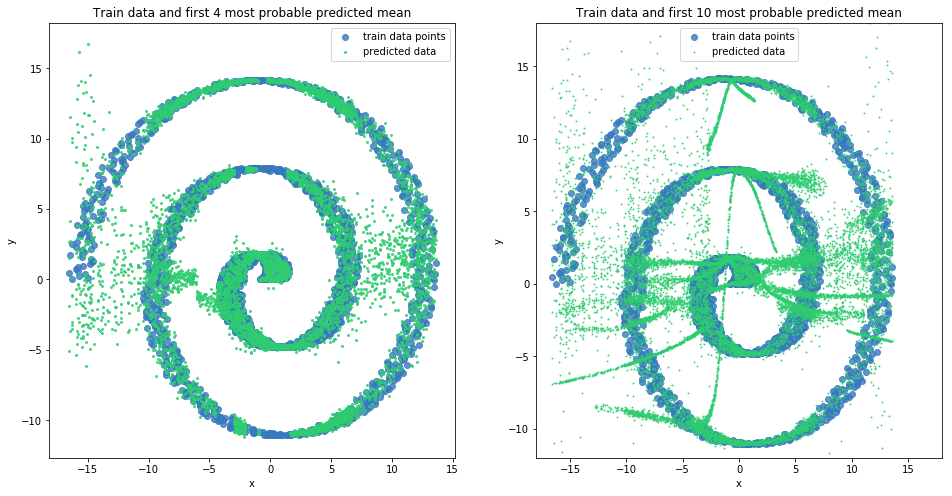

In [39]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1 = sns.regplot(x_test_compl, y_test_compl, fit_reg=False, ax=axes[0], color=sns.xkcd_palette(['windows blue'])[0])
for i in range(4):
    ax1 = sns.regplot(x_test_compl, fn_preds.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':4}, ax=axes[0], color=sns.color_palette(['#2ecc71'])[0])
ax1.set_title('Train data and first 4 most probable predicted mean')
ax1.legend(['train data points', 'predicted data'])
ax1.set(xlabel='x', ylabel='y')

ax2 = sns.regplot(x_test_compl, y_test_compl, fit_reg=False, ax=axes[1], color=sns.xkcd_palette(['windows blue'])[0])
for i in range(fn_preds.shape[1]):
    ax2 = sns.regplot(x_test_compl, fn_preds.data.numpy()[:, i], fit_reg=False, scatter_kws={'s':1}, ax=axes[1], color=sns.color_palette(['#2ecc71'])[0])
ax2.set_title('Train data and first 10 most probable predicted mean')
ax2.legend(['train data points', 'predicted data'])
ax2.set(xlabel='x', ylabel='y')
ax2.set_xlim(-18, 18)
ax2.set_ylim(-12, 18)
plt.show()